In [36]:
import torch
from torch import nn
import torch.nn.functional as F
from utils import View
from utils import train_network
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
D=28*28               # Dimension of the input data
n=2                   # no of hidden layers
C=1                   # no of channels
classes=10            # output classes

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [39]:
class AutoEncodeDataset(Dataset):
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs. 
    This makes it easy to re-use other code"""

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        return x, x # just throw away the original label.

In [40]:
train_data = AutoEncodeDataset(MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data_xy = MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncodeDataset(test_data_xy)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

In [41]:
x , l = next(iter(test_data_xy))
x.shape , l

(torch.Size([1, 28, 28]), 7)

In [42]:
x , l = next(iter(test_data_xx))
x.shape , l.shape

(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))

In [43]:
def get_layer(in_size,out_size):
    """
    in_size: how many neurons/features are coming into this layer
    out_size: how many neurons/outputs this hidden layer should produce
    """
    return nn.Sequential(
        nn.Linear(in_size,out_size),
        nn.BatchNorm1d(out_size),
        nn.ReLU()
    )

In [44]:
auto_encoder = nn.Sequential(
    nn.Flatten(),
    get_layer(D,D//2),
    get_layer(D//2,D//3),
    get_layer(D//3,D//4),
    nn.Linear(D//4,n)
)

auto_decoder = nn.Sequential(
    get_layer(n,D//4),
    get_layer(D//4,D//3),
    get_layer(D//3,D//2),
    nn.Linear(D//2,D),
    View(-1,1,28,28)
)

In [45]:
auto_encode_decode = nn.Sequential(
    auto_encoder,
    auto_decoder
)

In [47]:
train_network(model=auto_encode_decode,loss_func=nn.MSELoss(),
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=3,
            device=device)

Epoch: 100%|██████████| 3/3 [00:33<00:00, 11.08s/it]


,epoch,total time,train loss,test loss
0,0,10.795848,0.049757,0.043857
1,1,20.315408,0.043361,0.041663
2,2,29.686404,0.042006,0.040544


In [48]:
def encode_batch(encoder,dataset_to_encode):
    """
    encoder: the PyTorch network that takes in a dataset and convers it to a new dimension
    dataset_to_encode: a PyTorch `Dataset` object that we want to convert. 

    Returns a tuple (projected, labels) where `projected` is the encoded version of the dataset,
    and `labels` are the original labels provided by the `dataset_to_encode`
    """
    projected = []
    labels = []
    # put the encode to evaluation mode and pass it to the cpu
    encoder = encoder.eval()
    encoder = encoder.cpu()
    with torch.inference_mode():
        for x,y in DataLoader(dataset_to_encode,batch_size=128):
            z = encoder(x.cpu()) # move x to cpu just in case it wasn't already there
            projected.append(z.numpy())
            labels.append(y.cpu().numpy().ravel())

    projected = np.vstack(projected)
    labels = np.hstack(labels)
    
    return projected , labels

In [49]:
projected , labels = encode_batch(auto_encode_decode,test_data_xy)
projected.shape , projected.ndim

((10000, 1, 28, 28), 4)

In [50]:
projected , labels = encode_batch(auto_encoder,test_data_xy)
projected.shape , projected.ndim

((10000, 2), 2)

In [51]:
projected[:,1].shape

(10000,)

<Axes: >

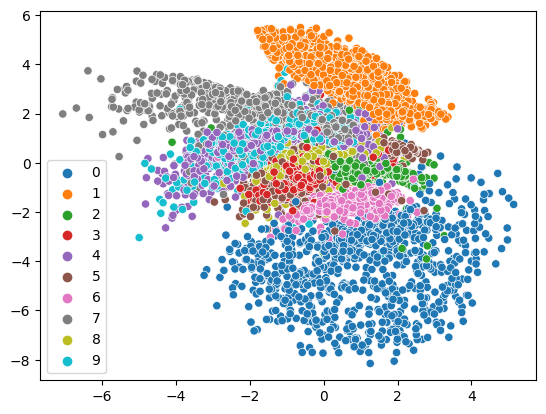

In [53]:
sns.scatterplot(
    x=projected[:,0],
    y=projected[:,1],
    hue=[str(l) for l in labels],
    hue_order=[str(i) for i in range(10)],
    legend="full")

In [54]:
def show_encode_decode(encode_decode,x):
    """
    encode_decode: the PyTorch Module that does the encoding and decoding steps at once
    x: the input to plot as is, and after encoding & decoding it
    """
    encode_decode = encode_decode.eval()
    encode_decode = encode_decode.cpu()
    with torch.inference_mode():
        x_recon = encode_decode(x.cpu())
        f , axarr = plt.subplots(1,2)
    axarr[0].imshow(x.numpy()[0,:])
    axarr[1].imshow(x_recon.numpy()[0,0,:])

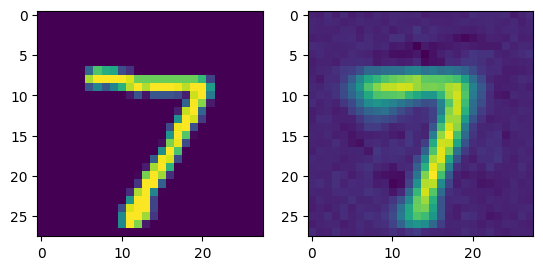

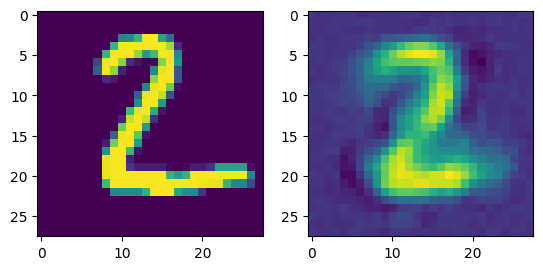

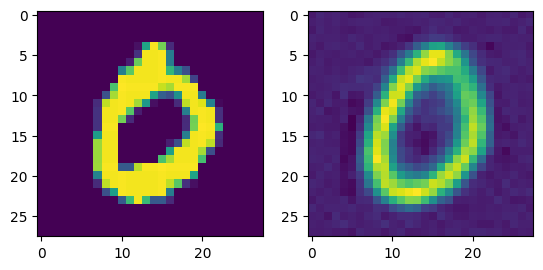

In [55]:
show_encode_decode(auto_encode_decode,test_data_xx[0][0])
show_encode_decode(auto_encode_decode,test_data_xx[1][0])
show_encode_decode(auto_encode_decode,test_data_xx[3][0])

## This part to add noise to a ceratain sample and see how the network works with that

In [56]:
# add noise function
normal = torch.distributions.Normal(0,0.5)
def addNoise(x,device='cpu'):
    """
    We will use this helper function to add noise to some data.
    x: the data we want to add noise to
    device: the CPU or GPU that the input is located on.
    """
    return x + normal.sample(sample_shape=torch.Size(x.shape)).to(device)

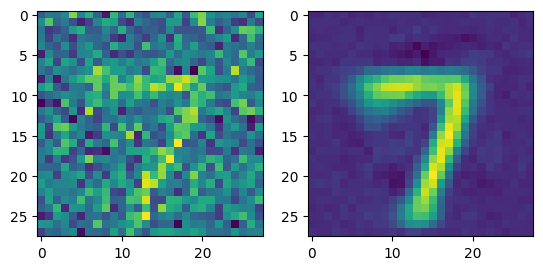

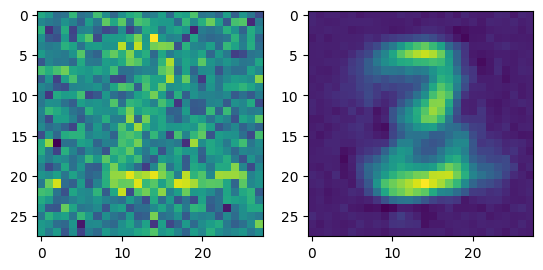

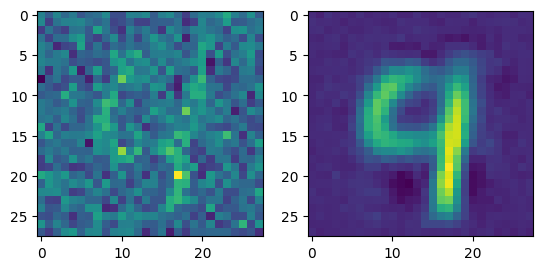

In [58]:
show_encode_decode(auto_encode_decode,addNoise(test_data_xy[0][0]))
show_encode_decode(auto_encode_decode,addNoise(test_data_xy[1][0]))
show_encode_decode(auto_encode_decode,addNoise(test_data_xy[4][0]))